In [71]:
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
import matplotlib.pyplot as plt
from keras.utils import image_dataset_from_directory
from sklearn.metrics import precision_score, accuracy_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
import splitfolders

In [4]:
df= pd.read_csv("/kaggle/input/state-farm-distracted-driver-detection/driver_imgs_list.csv")
df.head()

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg


In [5]:
import plotly.express as px
px.histogram(df , x="classname" ,  color="classname", title="Images By Categories ")

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22424 entries, 0 to 22423
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   subject    22424 non-null  object
 1   classname  22424 non-null  object
 2   img        22424 non-null  object
dtypes: object(3)
memory usage: 525.7+ KB


In [7]:
images = '/kaggle/input/state-farm-distracted-driver-detection/imgs/train'
splitfolders.ratio(images, output="images",
    seed=21, ratio=(.8, .2), group_prefix=None, move=False)

Copying files: 22424 files [01:47, 208.58 files/s]


In [8]:
train = '/kaggle/working/images/train'
val = '/kaggle/working/images/val'

In [9]:
import os
from PIL import Image

In [11]:
class_label= {
              'c0': 'Safe driving',
              'c1': 'Texting - right',
              'c2': 'Talking on the phone - right', 
              'c3': 'Texting - left', 
              'c4': 'Talking on the phone - left', 
              'c5': 'Operating the radio', 
              'c6': 'Drinking', 
              'c7': 'Reaching behind', 
              'c8': 'Hair and makeup', 
              'c9': 'Talking to passenger'
             }

In [12]:
subdirs = [subdir for subdir in os.listdir(train) if os.path.isdir(os.path.join(train, subdir))]
print(subdirs)

['c0', 'c4', 'c9', 'c2', 'c3', 'c6', 'c1', 'c8', 'c7', 'c5']


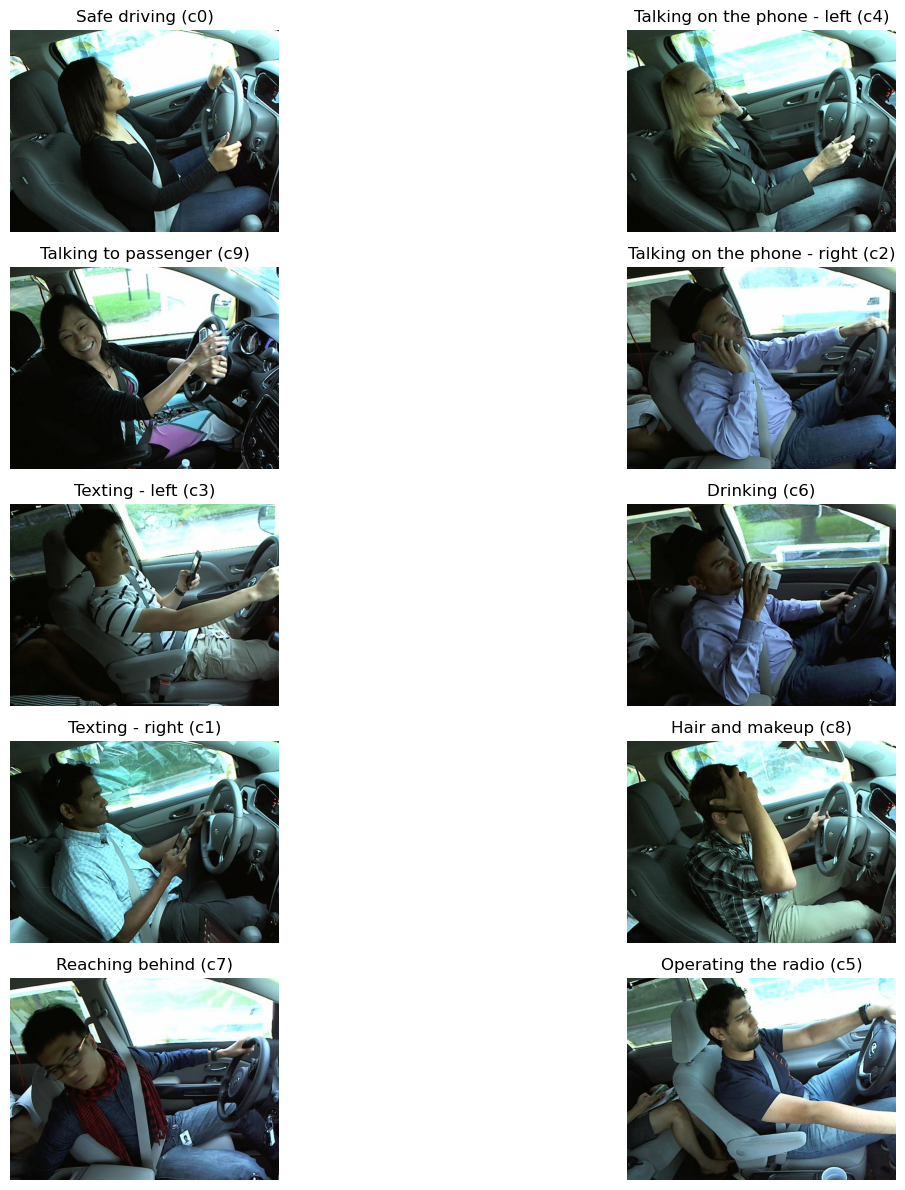

In [13]:
fig, axs = plt.subplots(5, 2, figsize=(16,12))

for i, subdir in enumerate(subdirs):
    file = os.listdir(os.path.join(train, subdir))[0]

    img = Image.open(os.path.join(train, subdir, file))
    axs[i//2, i%2].imshow(img)
    axs[i//2, i%2].set_title(f'{class_label[subdir]} ({subdir})')
    axs[i//2, i%2].axis('off')

plt.tight_layout()


In [23]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

batch_size = 128

train_generator = train_datagen.flow_from_directory(
        train,
        target_size=(256, 256),
        batch_size=128)

validation_generator = test_datagen.flow_from_directory(
        val,
        target_size=(256, 256),
        batch_size=128)

Found 17934 images belonging to 10 classes.
Found 4490 images belonging to 10 classes.


In [40]:
train_generator = image_dataset_from_directory(
                        directory="/kaggle/working/images/train",
                        image_size=(256, 256),
                        labels='inferred',
                        label_mode='categorical')
validation_generator = image_dataset_from_directory(
                        directory="/kaggle/working/images/val",
                        image_size=(256, 256),
                        labels='inferred',
                        label_mode='categorical')

rescale = Rescaling(scale=1/255)
train_generator = train_generator.map(lambda image,label:(rescale(image),label))
validation_generator  = validation_generator.map(lambda image,label:(rescale(image),label))

Found 17934 files belonging to 10 classes.
Found 4490 files belonging to 10 classes.


In [41]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomContrast

In [42]:
model = Sequential()
model.add(RandomFlip("horizontal", input_shape=(256,256,3)))
model.add(RandomContrast(0.5))

model.add(Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(256,256,3)))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(Dropout(0.2))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(Dropout(0.2))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
model.add(Dropout(0.2))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(512, (3,3), activation='relu', padding='same'))
model.add(Dropout(0.2))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(1024, (3,3), activation='relu', padding='same'))
model.add(Dropout(0.2))
model.add(MaxPooling2D(2,2))

model.add(Flatten())

model.add(Dense(512 , activation='relu' ))
model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_3 (RandomFlip)  (None, 256, 256, 3)       0         
                                                                 
 conv2d_18 (Conv2D)          (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 128, 128, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 64, 64, 64)       0         
 g2D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 64, 64, 64)       

In [43]:
from keras.callbacks import ReduceLROnPlateau
from keras.optimizers import Adam

opt = Adam(learning_rate=0.0001)

learning_rate_annealer = ReduceLROnPlateau(monitor='val_loss',
                                           reduce_factor=0.5, 
                                           min_lr=1e-7, patience=5)

model.compile(loss='categorical_crossentropy' , optimizer=opt , metrics=['accuracy'])

In [44]:
history = model.fit(train_generator, 
                    validation_data=validation_generator, 
                    callbacks=[learning_rate_annealer],
                    batch_size=128,
                    epochs=10)

Epoch 1/10


2023-04-25 11:45:12.393084: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_3/dropout_3/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


561/561 [==============================] - 68s 116ms/step - loss: 0.8473 - accuracy: 0.7079 - val_loss: 0.1972 - val_accuracy: 0.9399 - lr: 1.0000e-04
Epoch 2/10
561/561 [==============================] - 64s 113ms/step - loss: 0.1026 - accuracy: 0.9711 - val_loss: 0.0953 - val_accuracy: 0.9737 - lr: 1.0000e-04
Epoch 3/10
561/561 [==============================] - 63s 112ms/step - loss: 0.0464 - accuracy: 0.9869 - val_loss: 0.0746 - val_accuracy: 0.9822 - lr: 1.0000e-04
Epoch 4/10
561/561 [==============================] - 65s 115ms/step - loss: 0.0312 - accuracy: 0.9911 - val_loss: 0.0599 - val_accuracy: 0.9853 - lr: 1.0000e-04
Epoch 5/10
561/561 [==============================] - 64s 113ms/step - loss: 0.0267 - accuracy: 0.9930 - val_loss: 0.0299 - val_accuracy: 0.9935 - lr: 1.0000e-04
Epoch 6/10
561/561 [==============================] - 63s 111ms/step - loss: 0.0216 - accuracy: 0.9937 - val_loss: 0.0689 - val_accuracy: 0.9820 - lr: 1.0000e-04
Epoch 7/10
561/561 [===================

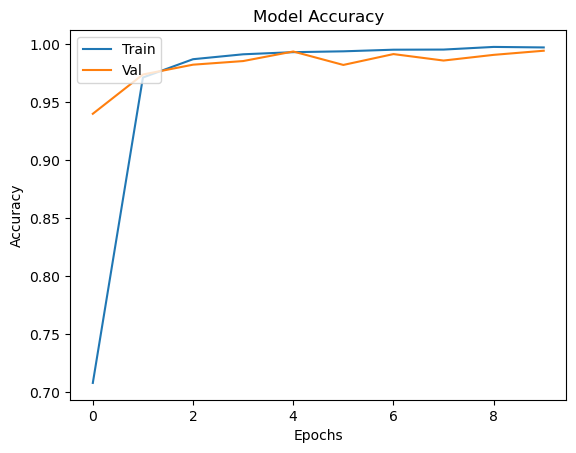

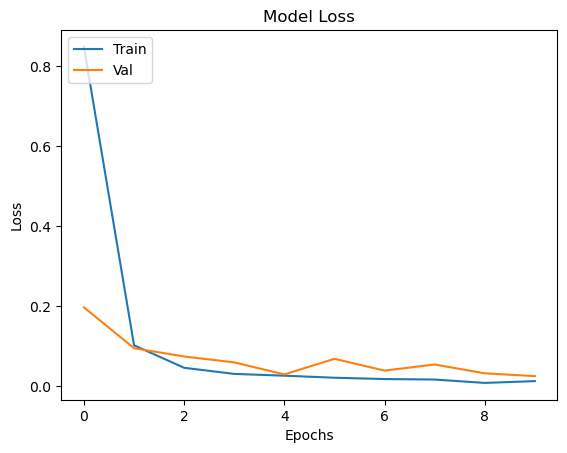

In [45]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')

plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')

plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [46]:
model.evaluate(train_generator)

561/561 [==============================] - 38s 66ms/step - loss: 0.0056 - accuracy: 0.9989


[0.005550568923354149, 0.9988847970962524]

In [48]:
model.evaluate(validation_generator)

141/141 [==============================] - 9s 63ms/step - loss: 0.0256 - accuracy: 0.9942


[0.025641055777668953, 0.994209349155426]

In [65]:
labels = []
predictions = []
for x,y in validation_generator:
    labels.append(list(y.numpy()))
    predictions.append(tf.argmax(model.predict(x),1).numpy())

1/1 [==============================] - 0s 24ms/step


In [66]:
predictions = list(itertools.chain.from_iterable(predictions))
labels = list(itertools.chain.from_iterable(labels))

In [68]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix, classification_report
n_classes = len(labels[0])
predictions = label_binarize(predictions, classes=np.arange(n_classes))

In [69]:
print("Train Accuracy  : {:.2f} %".format(history.history['accuracy'][-1]*100))
print("Test Accuracy   : {:.2f} %".format(accuracy_score(labels, predictions) * 100))
print("Precision Score : {:.2f} %".format(precision_score(labels, predictions, average='micro') * 100))
print("Recall Score    : {:.2f} %".format(recall_score(labels, predictions, average='micro') * 100))

Train Accuracy  : 99.70 %
Test Accuracy   : 99.42 %
Precision Score : 99.42 %
Recall Score    : 99.42 %


<Figure size 2000x500 with 0 Axes>

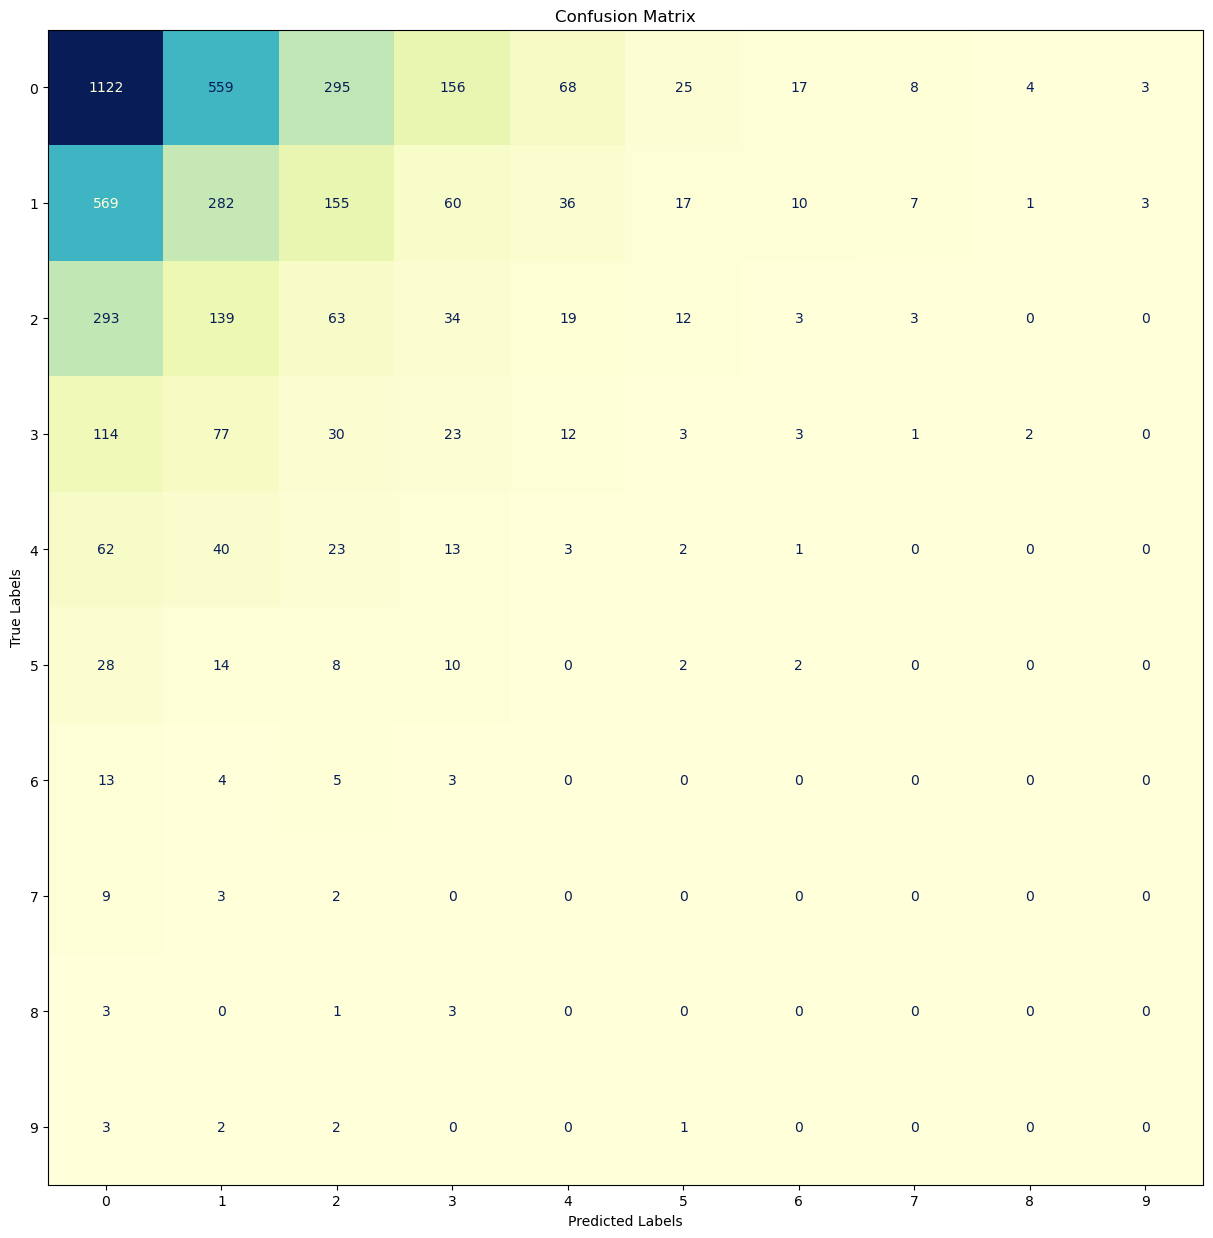

In [88]:
labels_1d = np.argmax(labels, axis=1)
predictions_1d = np.argmax(predictions, axis=1)

plt.figure(figsize= (20,5))
cm = confusion_matrix(labels_1d, predictions_1d)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=list(range(10)))
fig, ax = plt.subplots(figsize=(15,15))
disp.plot(ax=ax,colorbar= False,cmap = 'YlGnBu')
plt.title("Confusion Matrix")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()